# Ієрархічний кластерний аналіз даних

Вихідні дані завдання:

In [1]:
features = ['X2', 'X3', 'X6', 'X7'] # цільові ознаки

metrics = ['seuclidean', 'mahalanobis', 'chebyshev'] # метрики
methods = ['single', 'complete', 'average'] # методи зв'язування

##### Метрики, що використовуються:
- seuclidean - стандартизована евклідова відстань
- mahalanobis - Махаланобіса
- chebyshev - Чебишева


##### Методи зв'язування, що використовуються:
- single - ближнього сусіда
- complete - далекого сусіда
- average - середнього зв'язку

Підключуємо залежності:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram

from matplotlib import pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')

Зчитуємо дані про продукти:

In [3]:
products = pd.read_csv('products.csv')
products.head()

,X0,X2,X3,X6
0,Росія,3.9,30.0,124
1,Австралія,2.6,47.0,87
2,Австрія,5.3,37.0,74
3,Азербайджан,4.1,12.4,141
4,Вірменія,3.7,4.3,134


Зчитуємо дані про рівень життя:

In [4]:
standards_of_living = pd.read_csv('standards_of_living.csv')
standards_of_living.head()

,X0,X7
0,Росія,44.5
1,Австралія,32.5
2,Австрія,33.9
3,Азербайджан,38.8
4,Вірменія,34.4


Об'єднуємо дві таблиці: 

In [5]:
countries = pd.merge(products, standards_of_living)
countries.head()

,X0,X2,X3,X6,X7
0,Росія,3.9,30.0,124,44.5
1,Австралія,2.6,47.0,87,32.5
2,Австрія,5.3,37.0,74,33.9
3,Азербайджан,4.1,12.4,141,38.8
4,Вірменія,3.7,4.3,134,34.4


Нoрмалізуємо дані:

In [6]:
countries[features] = StandardScaler().fit_transform(countries[features])
countries.head()

,X0,X2,X3,X6,X7
0,Росія,0.181147,-0.033091,0.439253,0.884084
1,Австралія,-0.630893,1.487313,-0.709324,-0.453748
2,Австрія,1.055652,0.592958,-1.112878,-0.297668
3,Азербайджан,0.306077,-1.607156,0.966978,0.248614
4,Вірменія,0.056218,-2.331584,0.749679,-0.241925


Візуалізуємо залежність між різними ознаками і розподіл кожнoї окремої ознаки:

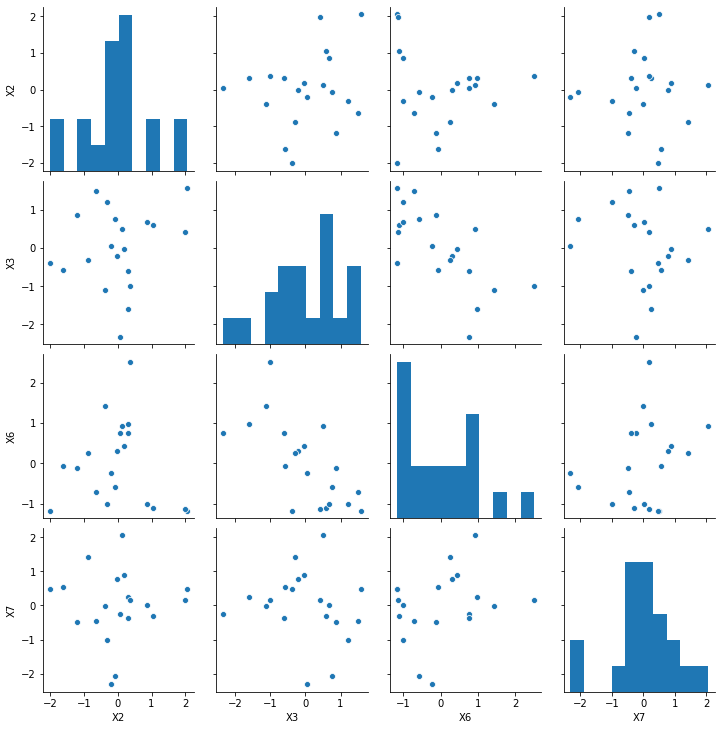

In [7]:
sns.pairplot(countries[features], diag_kind='hist')

Для деталізації візуалізуємо залежність між двома першими ознаками з підписами країн:

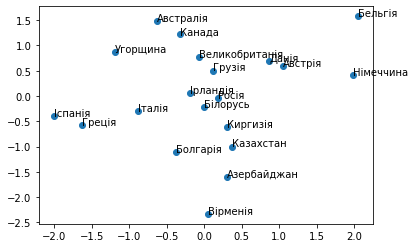

In [8]:
fig, ax = plt.subplots()
xs = countries[features[0]]
ys = countries[features[1]]
ax.scatter(xs, ys)

for i, txt in enumerate(countries['X0']):
    ax.annotate(txt, (xs[i],ys[i]))

Для кожної метрики и методу зв'язування підрахуємо відстані між об'єктами за допомогою функції pdist, Проведемо Кластерний аналіз за допомогою Функції linkage и Знайдемо коефіцієнти кофенетичної кореляції:

In [9]:
cophenet_coefs = pd.DataFrame(columns=metrics, index=methods, data=np.zeros((len(methods),len(metrics))))
X = countries[features].values

for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        y = pdist(X, metric, p=4)
        clustering = linkage(y, method)
        k = cophenet(clustering, y)
        cophenet_coefs.iloc[i, j] = k[0]

cophenet_coefs

,seuclidean,mahalanobis,chebyshev
single,0.711502,0.590072,0.623862
complete,0.714839,0.517176,0.634918
average,0.749043,0.686904,0.657578


Знайдемо максимальний і мінімальний з отриманих коефіцієнтів:

In [10]:
max_row_idx, max_col_idx = np.unravel_index(cophenet_coefs.values.argmax(), cophenet_coefs.values.shape)
print('Max coef: {} method and {} distance'.format(methods[max_row_idx], metrics[max_col_idx]))

min_row_idx, min_col_idx = np.unravel_index(cophenet_coefs.values.argmin(), cophenet_coefs.values.shape)
print('Min coef: {} method and {} distance'.format(methods[min_row_idx], metrics[min_col_idx]))

Max coef: average method and seuclidean distance
Min coef: complete method and mahalanobis distance


Для подальшого аналізу буде використовуватися метрика і метод, для яких коефіцієнт кофенетичної кореляції максимальний.

Побудуємо дендрограму результатів кластерного аналізу:

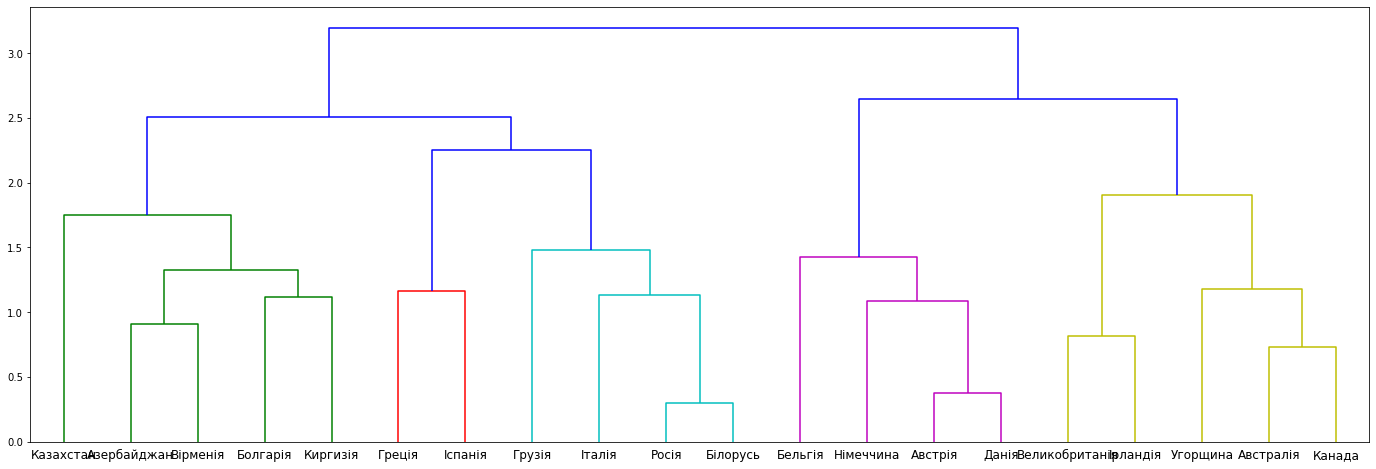

In [11]:
y = pdist(X, metrics[max_col_idx], p=4)
Z = linkage(y, methods[max_row_idx])

fig, ax = plt.subplots(figsize=(24, 8))
dn = dendrogram(Z, labels=countries['X0'].tolist())

Виділимо кластери шляхом завдання максимальної кількості кластерів n_clusters:

In [12]:
n_clusters = 4

from scipy.cluster.hierarchy import fcluster

maxclust_clusters = fcluster(Z, n_clusters, criterion='maxclust')

for i in range(np.unique(maxclust_clusters).shape[0]):
    print('Cluster #{}'.format(i + 1))
    
    for index, cluster in enumerate(maxclust_clusters):
        if cluster == (i + 1):
            print(countries['X0'].iloc[index], end=', ')
            
    print('\n')

Cluster #1
Азербайджан, Вірменія, Болгарія, Казахстан, Киргизія, 

Cluster #2
Росія, Білорусь, Греція, Грузія, Іспанія, Італія, 

Cluster #3
Австрія, Бельгія, Німеччина, Данія, 

Cluster #4
Австралія, Великобританія, Угорщина, Ірландія, Канада, 



Візуалізуємо залежність між приналежністю до кластерів та вихідними ознаками. Кожен кластер виділено окремим кольором.

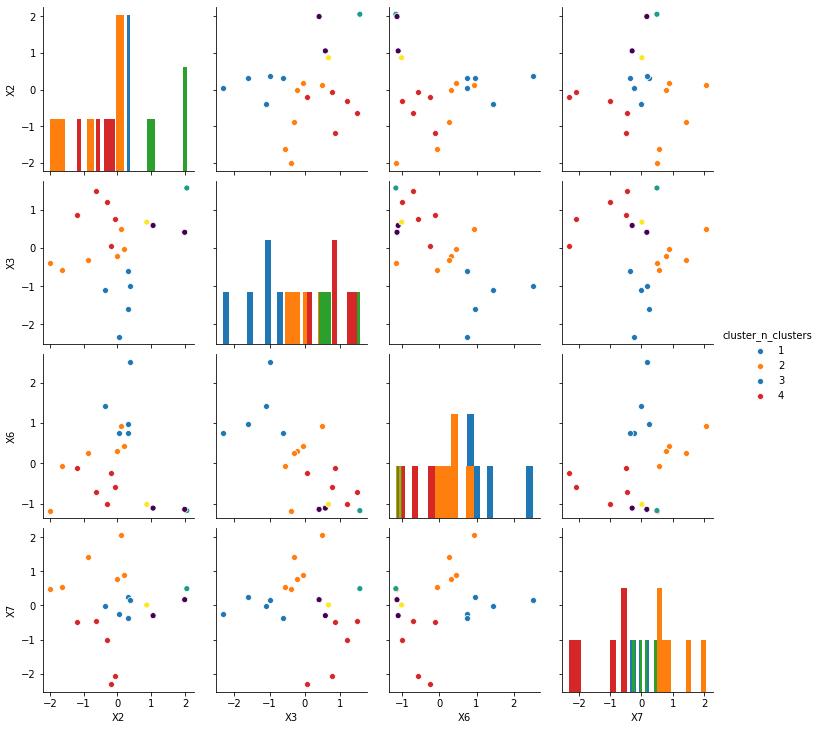

In [13]:
maxclust_result = countries[features]
maxclust_result['cluster_n_clusters'] = maxclust_clusters
sns.pairplot(maxclust_result, hue='cluster_n_clusters', diag_kind='hist')

Виділимо кластери шляхом завдання порогової відстані між кластерами max_dist:

In [14]:
max_dist = 2

from scipy.cluster.hierarchy import fcluster

distance_clusters = fcluster(Z, max_dist, criterion='distance')

for i in range(np.unique(distance_clusters).shape[0]):
    print('Cluster #{}'.format(i + 1))
    
    for index, cluster in enumerate(distance_clusters):
        if cluster == (i + 1):
            print(countries['X0'].iloc[index], end=', ')
            
    print('\n')

Cluster #1
Азербайджан, Вірменія, Болгарія, Казахстан, Киргизія, 

Cluster #2
Греція, Іспанія, 

Cluster #3
Росія, Білорусь, Грузія, Італія, 

Cluster #4
Австрія, Бельгія, Німеччина, Данія, 

Cluster #5
Австралія, Великобританія, Угорщина, Ірландія, Канада, 



Візуалізуємо залежність між приналежністю до кластерів та вихідними ознаками. Кожен кластер виділено окремим кольором.

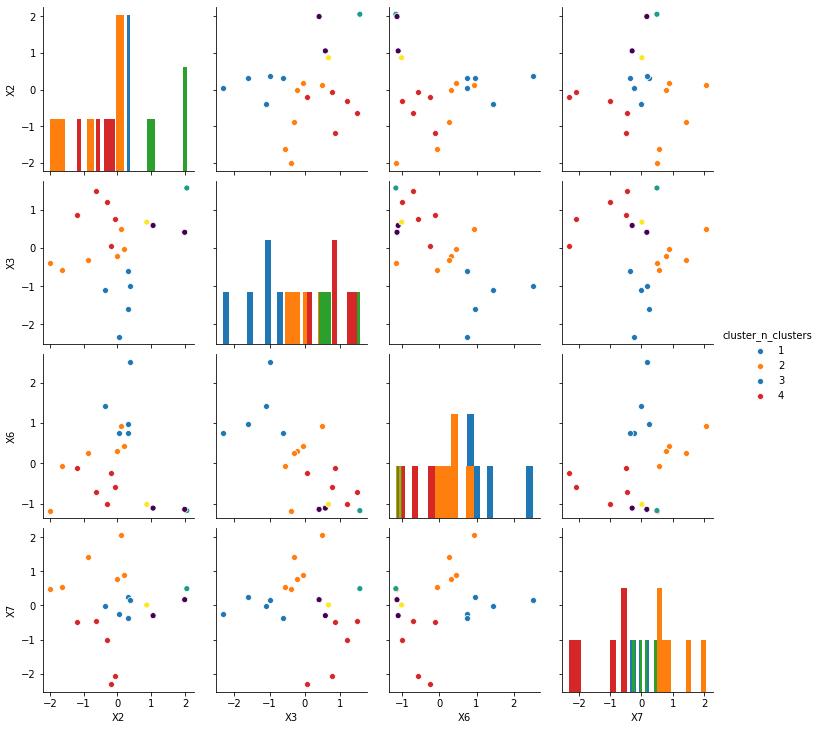

In [15]:
distance_result = countries[features]
distance_result['cluster_n_clusters'] = maxclust_clusters
sns.pairplot(distance_result, hue='cluster_n_clusters', diag_kind='hist')